In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

## Цель проекта: По данным ГТИ осуществлять опережающую геонавигацию (до LWD) в горизонтальной секции для предотвращения выхода из продуктивного пласта.

#### MD - глубина замера
#### ROPA - механическая скорость
#### RMPA - обороты ротора
#### TRQ - момент на роторе
#### WOBA - нагрузка на крюке
#### LITH - литология (1: песчаник, 2: глина)

## 1. Обзор данных

In [3]:
data = pd.read_csv('data_horizontal.csv')
lith = pd.read_csv('lith.csv')

In [4]:
display(data.head(5))
display(lith.head(5))

,MD,ROPA,RMPA,TRQ,WOBA
0,m,m/h,c/min,kN.m,1000 kgf
1,MD,ROP,RPM,TRQ,WOB
2,0,-999.25,-999.25,-999.25,-999.25
3,0.1524,-999.25,-999.25,-999.25,-999.25
4,0.3048,-999.25,-999.25,-999.25,-999.25


,MD,LITHO
0,m,NaN
1,MD,Lithology
2,0,-999.25
3,0.1524,-999.25
4,0.3048,-999.25


#### Шаг дискретизации данных буровой механики и литологии совпадают, можем сразу их объединить.

In [6]:
df = pd.merge(data, lith, on='MD', how='inner')
display(df.head(5))

,MD,ROPA,RMPA,TRQ,WOBA,LITHO
0,m,m/h,c/min,kN.m,1000 kgf,NaN
1,MD,ROP,RPM,TRQ,WOB,Lithology
2,0,-999.25,-999.25,-999.25,-999.25,-999.25
3,0.1524,-999.25,-999.25,-999.25,-999.25,-999.25
4,0.3048,-999.25,-999.25,-999.25,-999.25,-999.25


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29529 entries, 0 to 29528
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   MD      29529 non-null  object
 1   ROPA    29529 non-null  object
 2   RMPA    29529 non-null  object
 3   TRQ     29529 non-null  object
 4   WOBA    29529 non-null  object
 5   LITHO   29528 non-null  object
dtypes: object(6)
memory usage: 1.4+ MB


In [8]:
print(f'Количество пропущенных значений:\n{df.isnull().sum()}')

Количество пропущенных значений:
MD       0
ROPA     0
RMPA     0
TRQ      0
WOBA     0
LITHO    1
dtype: int64


#### Необходимо перейти к числовому типу данных, а также удалить первые две строки, связанные с единицами измерений и рабочими названиями каротажей

In [10]:
df = df.drop([0, 1])
df = df.apply(pd.to_numeric, errors='coerce')

display(df.head(5))

,MD,ROPA,RMPA,TRQ,WOBA,LITHO
2,0.0000,-999.25,-999.25,-999.25,-999.25,-999.25
3,0.1524,-999.25,-999.25,-999.25,-999.25,-999.25
4,0.3048,-999.25,-999.25,-999.25,-999.25,-999.25
5,0.4572,-999.25,-999.25,-999.25,-999.25,-999.25
6,0.6096,-999.25,-999.25,-999.25,-999.25,-999.25


#### Значения -999.25 означают отсутствие записи на данной глубине, их следует удалить.

In [12]:
df = df.loc[~(df == -999.25).any(axis=1)]

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4766 entries, 23405 to 28170
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   MD      4766 non-null   float64
 1   ROPA    4766 non-null   float64
 2   RMPA    4766 non-null   float64
 3   TRQ     4766 non-null   float64
 4   WOBA    4766 non-null   float64
 5   LITHO   4766 non-null   float64
dtypes: float64(6)
memory usage: 260.6 KB


In [13]:
display(df.head(3))

,MD,ROPA,RMPA,TRQ,WOBA,LITHO
23405,3566.6172,0.4914,120.897483,12.456286,1.357,2.0
23406,3566.7696,0.4152,120.817485,11.930419,0.976,2.0
23407,3566.9220,0.4000,120.699997,11.853216,1.144,2.0


#### Датасет подготовлен, переходим к более детальному рассмотрению данных.

## 2. Разведочный анализ данных

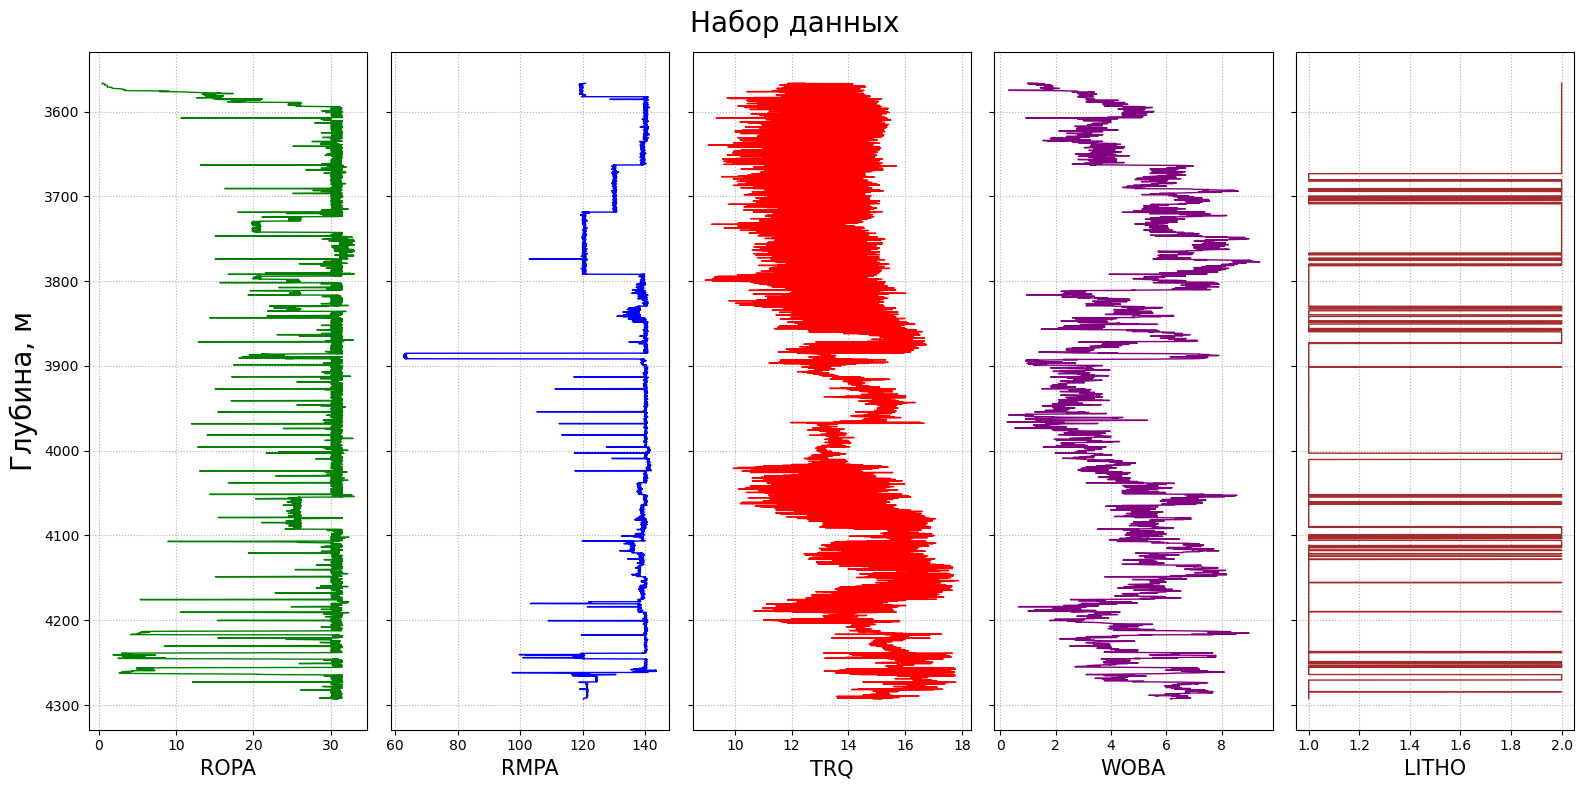

In [16]:
logs = [
    {'name': 'ROPA', 'color': 'green'},
    {'name': 'RMPA', 'color': 'blue'},
    {'name': 'TRQ', 'color': 'red'},
    {'name': 'WOBA', 'color': 'purple'},
    {'name': 'LITHO', 'color': 'brown'}
]

fig, axes = plt.subplots(1, 5, figsize=(16, 8), sharey=True)
fig.suptitle('Набор данных', fontsize=20)
axes[0].set_ylabel('Глубина, м', fontsize=20)

for ax, log in zip(axes, logs):
    ax.plot(df[log['name']], df['MD'], color=log['color'], linewidth=1)
    ax.set_xlabel(log['name'], fontsize=15)
    ax.grid(True, linestyle=':')
    ax.invert_yaxis()

plt.tight_layout()
plt.show()

#### Наблюдаются вылеты, зашумленность данных, дисбаланс целевого признака.

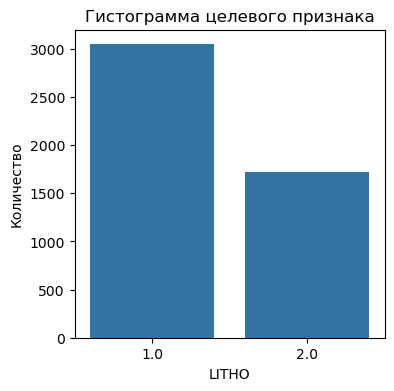

In [18]:
plt.figure(figsize=(4, 4))
sns.countplot(x=df['LITHO'])
plt.title('Гистограмма целевого признака')
plt.ylabel('Количество')
plt.show()

#### На этапе обучения модели необходимо будет сбалансировать классы.

#### Рассмотрим матрицу корреляции Спирмена, так как она более устойчива к выбросам и не требует нормального распределения. Описывает монотонную зависимость, в отличии от линейной Пирсона.

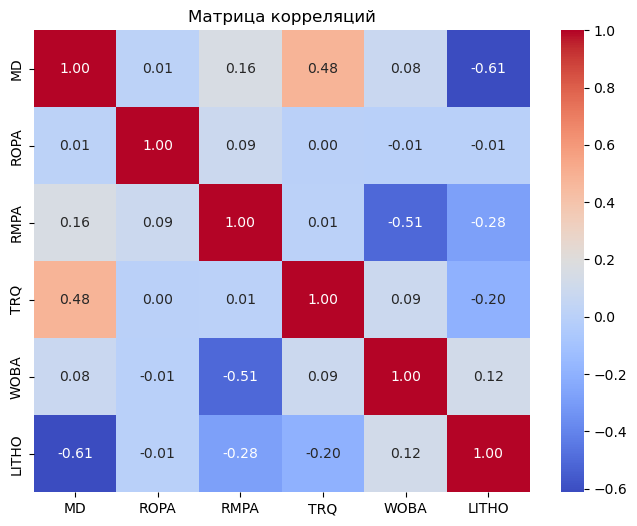

In [21]:
correlation_matrix = df.corr(method='spearman')

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Матрица корреляций')
plt.show()

#### Наблюдается корреляция литологии с нагрузкой, моментом на роторе и с оборотами. Рассмотрим детальнее.

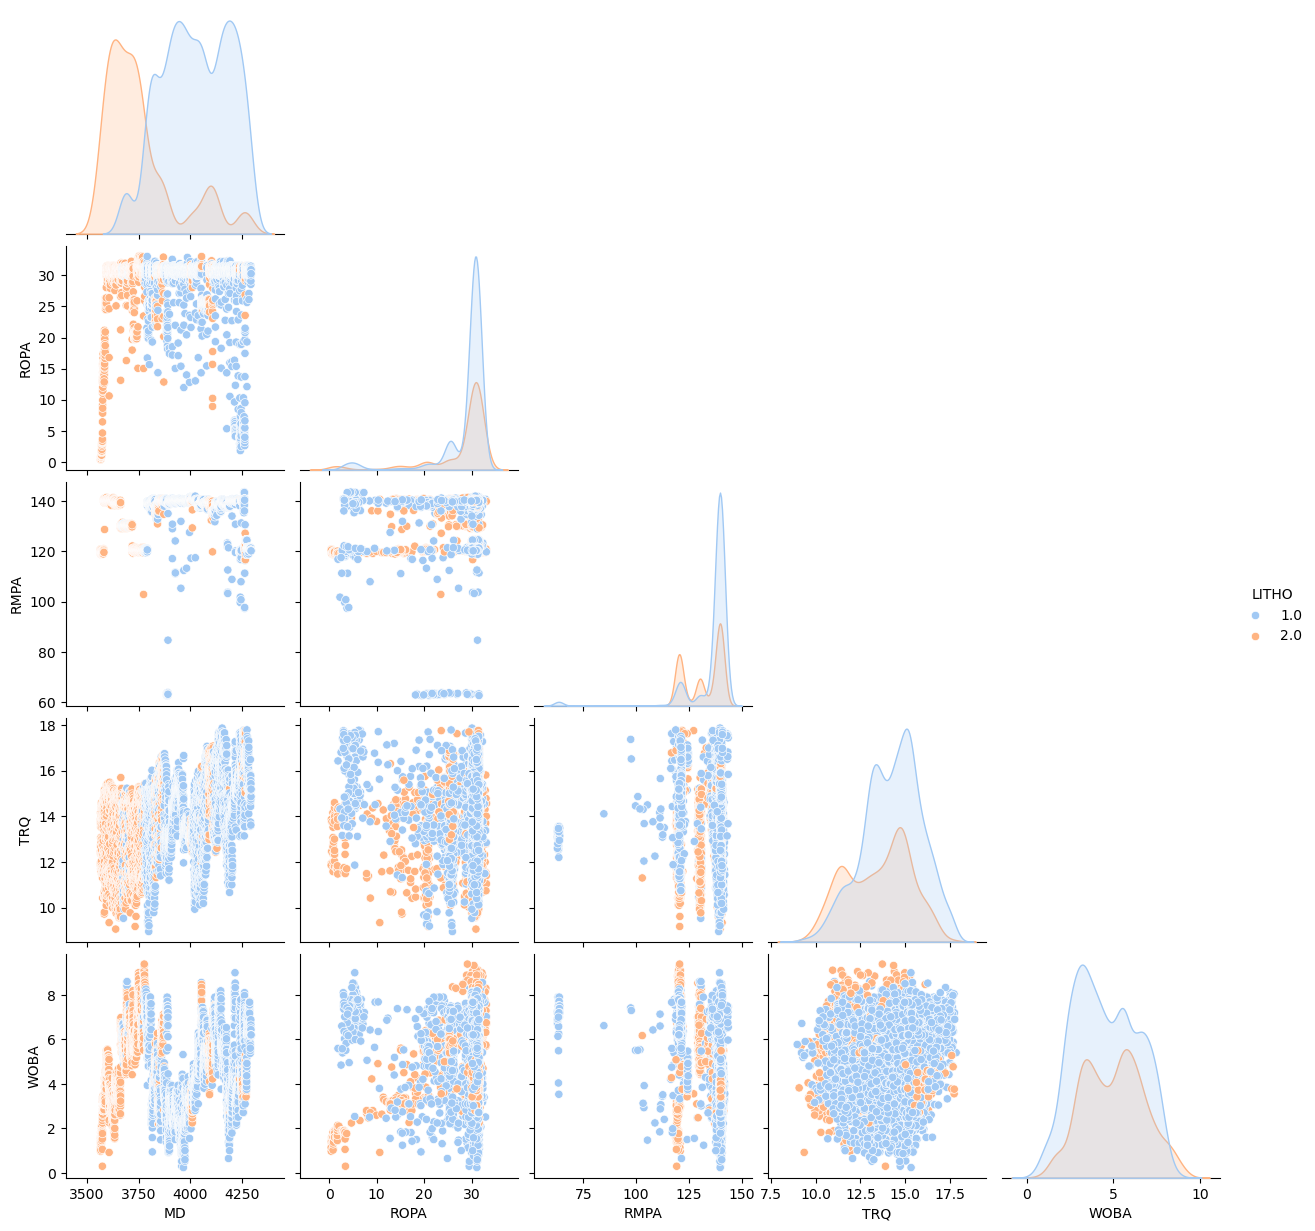

In [23]:
sns.pairplot(data = df, hue='LITHO', palette='pastel', corner=True)

#### Выделяются следующие особенности в распределении целевого признака:
#### Понижение механической скорости связано в большей степени с песчаниками;
#### Понижение оборотов на роторе связано с глинами;
#### Для песчаников характерно повышение моментов на роторе
#### Пониженная нагрузка в основном связана с песчаниками, а для глин наоборот выделяется пик на повышенных значениях.

<Figure size 1000x500 with 0 Axes>

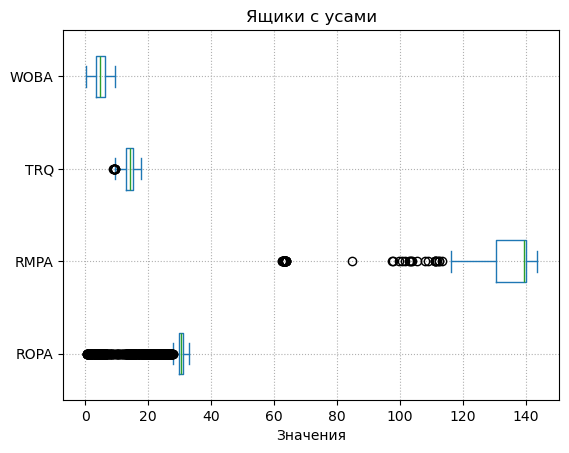

In [25]:
plt.figure(figsize=(10, 5))

df[['ROPA', 'RMPA', 'TRQ', 'WOBA']].plot(kind='box', vert=False)
plt.title('Ящики с усами')
plt.xlabel('Значения')
plt.grid(True, linestyle=':')
plt.show()

#### Ящики с усами показывают нам большое число вылетов, которые в том числе содержат в себе реальную информацию и должны удаляться с осторожностью. 
#### Если мы удалим стандартным методом данные за пределами верхней и нижней границ, то потеряем ценную информацию.
#### К тому же, при сопровождении горизонтальной секции в реальном времени мы будем неизбежно сталкиваться с вылетами, которые нужно будет обрабатывать, либо подавать на вход такими, какие они есть.
#### Попроубем обучить модель на исходных данных.

## 3. Обучение модели

In [28]:
RANDOM_STATE = 50

In [30]:
from sklearn.model_selection import train_test_split

X = df[['ROPA', 'RMPA', 'TRQ', 'WOBA']]
y = df['LITHO']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

#### Возьмем за основу Random Forest, который устойчив к шуму и учитывает дисбаланс классов.

In [32]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(class_weight='balanced', random_state=RANDOM_STATE)
model.fit(X_train, y_train)

print("Accuracy:", model.score(X_test, y_test))

Accuracy: 0.7976939203354297


#### Неплохой результат, посмотрим, сможем ли мы улучшить результат после оптимизации гиперпараметров.

In [56]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, accuracy_score
from sklearn.metrics import classification_report

params = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'class_weight': ['balanced', {1:1, 2:2}, {1:1, 2:3}]
}

grid = GridSearchCV(
    RandomForestClassifier(random_state=RANDOM_STATE),
    params,
    cv=3,
    scoring={'accuracy': 'accuracy', 'f1': 'f1_weighted'},
    refit='accuracy', 
    n_jobs=-1
)
grid.fit(X_train, y_train)

print("Лучшие параметры:", grid.best_params_)
model = grid.best_estimator_

y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Отчёт по классам: ")
print(classification_report(y_test, y_pred))

Лучшие параметры: {'class_weight': 'balanced', 'max_depth': 20, 'min_samples_split': 10, 'n_estimators': 50}
Accuracy: 0.79979035639413
Отчёт по классам: 
              precision    recall  f1-score   support

         1.0       0.83      0.87      0.85       610
         2.0       0.74      0.68      0.71       344

    accuracy                           0.80       954
   macro avg       0.79      0.77      0.78       954
weighted avg       0.80      0.80      0.80       954



In [58]:
importances = model.feature_importances_
print(pd.DataFrame({'Признак': X_train.columns, 'Важность': importances}))

  Признак  Важность
0    ROPA  0.176028
1    RMPA  0.356525
2     TRQ  0.230211
3    WOBA  0.237235


#### Есть небольшое улучшение после поиска гиперпараметров.
#### Максимальная глубина деревьев достигла максимума по сетке - 20, что говорит о сложных зависимостях и возможном переобучении.
#### Узлы дерева делятся при наличии минимум 10 образцов, что должно предотвращать переобучение.
#### Глины предсказываются хуже (0.71 против 0.85 для песчаников), что может быть связано с дисбалансом и требует доработки при возможности.

### Дальнейшие действия: 
#### 1. Добавить данные для тестовой выборки;
#### 2. Попробовать CatBoost/XGBoost, которые хорошо работают с дисбалансом;
#### 3. Попробовать SMOTE для балансировки классов;
#### 4. Попробовать изменить пороговое значение классификации.